# BEE 4750 Homework 5: Solid Waste Disposal

**Name**:

**ID**:

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

``` julia
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
```

``` julia
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
```

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

  Activating project at `c:\Users\henry\Downloads\4750\Homework\hw05-henrysigel`


## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee ** (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:-------------:|:-------------:|:-------------:|:----------:|:--------------:|
|           Landfill           |         200         |         2000          |            50            |                            |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |                            |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:---------------------:|:--------------:|:---------------:|:---------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

Percent Combustion Ash = 16.41
Percent Recycling = 37.75
Percent Combustion ash after Recycling = .11719

#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

Wij = Waste transported from city i to waste disposal j
Rkj = Residual waste from disposal k to disposal j
Yj = Operational Status of disposal j, binary

#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).


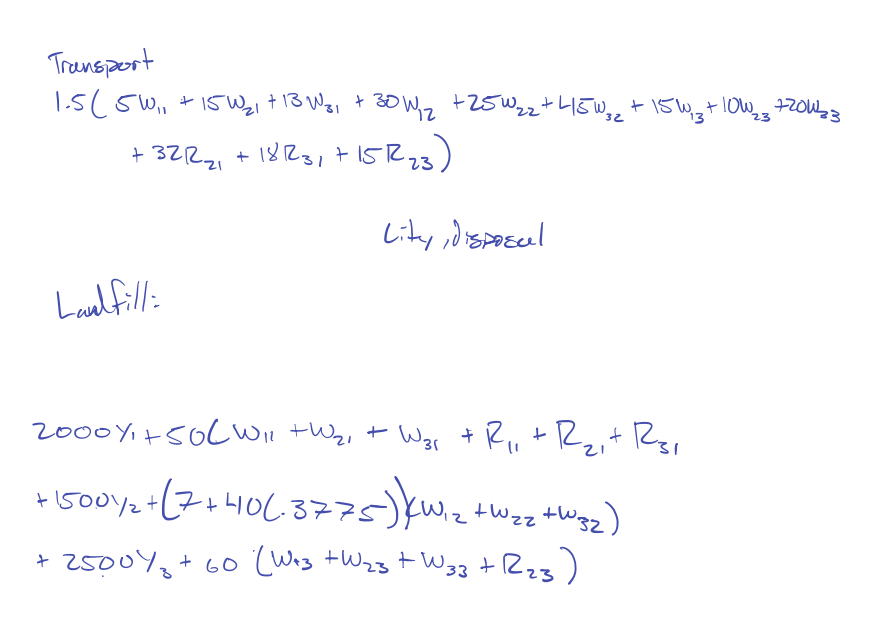


W11*(57.5) + W21*(72.5) + W31*(69.5) + W12*(56.9) + W22*(49.4) + W32*(79.4) + W13*(82.5) + W23*(75) + W33*(90) + R21*(98) + R31*(77) + R23*(82.5) + 2000Y1 + 1500Y2 + 2500*Y3



#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.


sum_j(Wij) = Si  where Si is equal to the total waste from each source i

sum_i(Wij) <= Kj where Kj is the max disposal at disposal j

Wij >= 0


W11 + W12 + W13 = 100

W21 + W22 + W23 = 90

W31 + W32 + W33 = 120

W11 + W21 + W31 +R21 +R31 <= 200

W12 + W22 + W32 <= 350

W13 + W23 + W33 + R23 <= 210

R21 + R23 = (1-.3775) *(W21 +W22 +W23)

R31 = (W31+W32+W33)*(1-.1641) + R23*(1-.11719)

Y1 = 1 if Sum(W1,j) >0
Y2 = 1 if Sum(W2,j) >0
Y3 = 1 if Sum(W3,j) >0

Wi,j and Rk,j >= 0



#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [7]:
I = 1:3
J = 1:3
K = 1:3
Waste_Transport_Model = Model(HiGHS.Optimizer)

@variable(Waste_Transport_Model, W[i in I, j in J] >= 0)
@variable(Waste_Transport_Model, R[k in K, j in J] >= 0)
@variable(Waste_Transport_Model, Y[j in J], binary = true)


@constraint(Waste_Transport_Model, W[1,1] + W[1,2] + W[1,3] == 100)
@constraint(Waste_Transport_Model, W[2,1] + W[2,2] + W[2,3] == 90)
@constraint(Waste_Transport_Model, W[3,1] + W[3,2] + W[3,3] == 120)
@constraint(Waste_Transport_Model, W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] <= 200)
@constraint(Waste_Transport_Model, W[1,2] + W[2,2] + W[3,2] <= 350)
@constraint(Waste_Transport_Model, W[1,3] + W[2,3] + W[3,3] + R[2,3] <= 210)
@constraint(Waste_Transport_Model, R[2,1] + R[2,3] == (1-.3775) *(W[2,1] +W[2,2] +W[2,3]))
@constraint(Waste_Transport_Model, R[3,1] <= (W[3,1]+W[3,2]+W[3,3])*(1-.1641) + R[2,3]*(1-.11719))

if (W[1, 1] + W[2, 1] + W[3, 1] + R[1, 1] + R[2, 1] + R[3, 1] == 0)
    @constraint(Waste_Transport_Model, Y[1] == 0)
else
    @constraint(Waste_Transport_Model, Y[1] == 1)
end
if (W[1, 2] + W[2, 2] + W[3, 2] + R[1, 2] + R[2, 2] + R[3, 2] == 0)
    @constraint(Waste_Transport_Model, Y[2] == 0)
else
    @constraint(Waste_Transport_Model, Y[2] == 1)
end
if (W[1, 3] + W[2, 3] + W[3, 3] + R[1, 3] + R[2, 3] + R[3, 3] == 0)
    @constraint(Waste_Transport_Model, Y[3] == 0)
else
    @constraint(Waste_Transport_Model, Y[3] == 1)
end

@objective(Waste_Transport_Model, Min, 57.5*W[1,1]+72.5*W[2,1]+69.5*W[3,1]+56.9*W[1,2]+49.4*W[2,2]+ 79.4*W[3,2]+ 82.5*W[1,3]+75*W[2,3]+90*W[3,3]+98*R[2,1]+77*R[3,1]+82.5*R[2,3]+2000*Y[1]+1500*Y[2]+2500*Y[3])


57.5 W[1,1] + 72.5 W[2,1] + 69.5 W[3,1] + 56.9 W[1,2] + 49.4 W[2,2] + 79.4 W[3,2] + 82.5 W[1,3] + 75 W[2,3] + 90 W[3,3] + 98 R[2,1] + 77 R[3,1] + 82.5 R[2,3] + 2000 Y[1] + 1500 Y[2] + 2500 Y[3]

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [8]:
# Solve the model
optimize!(Waste_Transport_Model)

# Display the results
println("Objective Value: ", objective_value(Waste_Transport_Model))
println("Waste Transport Matrix:")
println(value.(W))
println("Recycle Matrix:")
println(value.(R))
println("Selected Destinations:")
println(value.(Y))

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
7 rows, 10 cols, 24 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      29098.0625
  Dual bound        29098.0625
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    29098.0625 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.00 (total)
                    0.00 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                    0 (separation)
                    0 (heuristics)
Objective Value: 29098.0625


Waste Transport Matrix:
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
   0.0  100.0  0.0
   0.0   90.0  0.0
 120.0    0.0  0.0


Recycle Matrix:
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
 0.0  0.0   0.0
 0.0  0.0  56.025000000000006
 0.0  0.0   0.0
Selected Destinations:
1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{Float64}:
 1.0
 

1.0
 1.0

#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

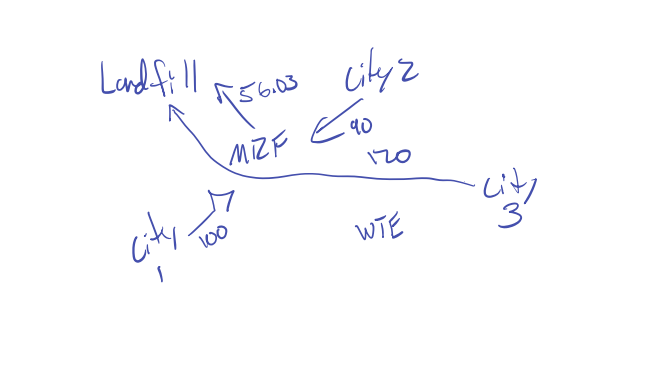

WTE is not being used which makes sense. This is far less effecient then the recycling facility, so the majority of the trash is routed through the recylcing center then then sent to the landfill.

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

I need to change my objective function and add a contraint. I need to change the value of some of my inputs becuase of the carbon tax, and then I need to add a fourth column to W in order to account for the landfill.

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [4]:
I = 1:3
J = 1:3
K = 1:3
Waste_Transport_Model = Model(HiGHS.Optimizer)

@variable(Waste_Transport_Model, W[i in I, j in J] >= 0)
@variable(Waste_Transport_Model, R[k in K, j in J] >= 0)
@variable(Waste_Transport_Model, Y[j in J], binary = true)


@constraint(Waste_Transport_Model, W[1,1] + W[1,2] + W[1,3] == 100)
@constraint(Waste_Transport_Model, W[2,1] + W[2,2] + W[2,3] == 90)
@constraint(Waste_Transport_Model, W[3,1] + W[3,2] + W[3,3] == 120)
@constraint(Waste_Transport_Model, W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] <= 200)
@constraint(Waste_Transport_Model, W[1,2] + W[2,2] + W[3,2] <= 350)
@constraint(Waste_Transport_Model, W[1,3] + W[2,3] + W[3,3] + R[2,3] <= 210)
@constraint(Waste_Transport_Model, R[2,1] + R[2,3] == (1-.3775) *(W[2,1] +W[2,2] +W[2,3]))
@constraint(Waste_Transport_Model, R[3,1] <= (W[3,1]+W[3,2]+W[3,3])*(1-.1641) + R[2,3]*(1-.11719))

if (W[1, 1] + W[2, 1] + W[3, 1] + R[1, 1] + R[2, 1] + R[3, 1] == 0)
    @constraint(Waste_Transport_Model, Y[1] == 0)
else
    @constraint(Waste_Transport_Model, Y[1] == 1)
end
if (W[1, 2] + W[2, 2] + W[3, 2] + R[1, 2] + R[2, 2] + R[3, 2] == 0)
    @constraint(Waste_Transport_Model, Y[2] == 0)
else
    @constraint(Waste_Transport_Model, Y[2] == 1)
end
if (W[1, 3] + W[2, 3] + W[3, 3] + R[1, 3] + R[2, 3] + R[3, 3] == 0)
    @constraint(Waste_Transport_Model, Y[3] == 0)
else
    @constraint(Waste_Transport_Model, Y[3] == 1)
end

@objective(Waste_Transport_Model, Min, 60*W[1,1]+246.7*W[2,1]+182.7*W[3,1]+166.7*W[1,2]+156.7*W[2,2]+ 196.7*W[3,2]+ 30*W[1,3]+20*W[2,3]+40*W[3,3]+50*R[1,1]+114*R[2,1]+86*R[3,1]+30*R[2,3]+2000*Y[1]+1500*Y[2]+2500*Y[3]+75*W[1,3]+75*W[2,3]+75*W[3,3]+75*R[2,3])



60 W[1,1] + 246.7 W[2,1] + 182.7 W[3,1] + 166.7 W[1,2] + 156.7 W[2,2] + 196.7 W[3,2] + 105 W[1,3] + 95 W[2,3] + 115 W[3,3] + 50 R[1,1] + 114 R[2,1] + 86 R[3,1] + 105 R[2,3] + 2000 Y[1] + 1500 Y[2] + 2500 Y[3]

In [5]:
I = 1:4
J = 1:3
K = 1:3
Waste_Transport_Model = Model(HiGHS.Optimizer)

@variable(Waste_Transport_Model, W[i in I, j in J] >= 0)
@variable(Waste_Transport_Model, R[k in K, j in J] >= 0)
@variable(Waste_Transport_Model, Y[j in J], binary = true)


@constraint(Waste_Transport_Model, W[1,1] + W[1,2] + W[1,3] == 100)
@constraint(Waste_Transport_Model, W[2,1] + W[2,2] + W[2,3] == 90)
@constraint(Waste_Transport_Model, W[3,1] + W[3,2] + W[3,3] == 120)
@constraint(Waste_Transport_Model, W[4,1] + W[4,2] + W[4,3] == 100)
@constraint(Waste_Transport_Model, W[1,1] + W[2,1] + W[3,1] + W[4,1] + R[2,1] + R[3,1] <= 200)
@constraint(Waste_Transport_Model, W[1,2] + W[2,2] + W[3,2] + W[4,2] <= 350)
@constraint(Waste_Transport_Model, W[1,3] + W[2,3] + W[3,3] + W[4,3] + R[2,3] <= 210)
@constraint(Waste_Transport_Model, R[2,1] + R[2,3] == (1-.3775) *(W[2,1] +W[2,2] +W[2,3]))
@constraint(Waste_Transport_Model, R[3,1] <= (W[3,1]+W[3,2]+W[3,3])*(1-.1641) + R[2,3]*(1-.11719))

if (W[1, 1] + W[2, 1] + W[3, 1] + R[1, 1] + R[2, 1] + R[3, 1] == 0)
    @constraint(Waste_Transport_Model, Y[1] == 0)
else
    @constraint(Waste_Transport_Model, Y[1] == 1)
end
if (W[1, 2] + W[2, 2] + W[3, 2] + R[1, 2] + R[2, 2] + R[3, 2] == 0)
    @constraint(Waste_Transport_Model, Y[2] == 0)
else
    @constraint(Waste_Transport_Model, Y[2] == 1)
end
if (W[1, 3] + W[2, 3] + W[3, 3] + R[1, 3] + R[2, 3] + R[3, 3] == 0)
    @constraint(Waste_Transport_Model, Y[3] == 0)
else
    @constraint(Waste_Transport_Model, Y[3] == 1)
end

@objective(Waste_Transport_Model, Min, 60*W[1,1] + 246.7*W[2,1] + 182.7*W[3,1] + 90*W[4,1] + 166.7*W[1,2] + 156.7*W[2,2] + 196.7*W[3,2] + 176.7*W[4,2] + 30*W[1,3] + 20*W[2,3] + 40*W[3,3] + 30*W[4,3] + 64*R[2,1] + 36*R[3,1] + 30*R[2,3] + 2000*Y[1] + 1500*Y[2] + 2500*Y[3] + 75*W[1,3] + 75*W[2,3] + 75*W[3,3] + 75*R[2,3])


60 W[1,1] + 246.7 W[2,1] + 182.7 W[3,1] + 90 W[4,1] + 166.7 W[1,2] + 156.7 W[2,2] + 196.7 W[3,2] + 176.7 W[4,2] + 105 W[1,3] + 95 W[2,3] + 115 W[3,3] + 30 W[4,3] + 64 R[2,1] + 36 R[3,1] + 105 R[2,3] + 2000 Y[1] + 1500 Y[2] + 2500 Y[3]

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [6]:
# Solve the model
optimize!(Waste_Transport_Model)

# Display the results
println("Objective Value: ", objective_value(Waste_Transport_Model))
println("Waste Transport Matrix:")

for i in I
    for j in J
        println("W[$i,$j] = ", value(W[i, j]))
    end
end


Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
9 rows, 15 cols, 37 nonzeros
7 rows, 13 cols, 26 nonzeros

Solving MIP model with:
   7 rows
   13 cols (0 binary, 0 integer, 0 implied int., 13 continuous)
   26 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   9585.6          inf                  inf        0      0      0         0     0.0s
 T       0       0         0   0.00%   9585.6          56927.4191        83.16%        0      0      0         7     0.0s

Solving report
  Status            Optimal
  Primal bound      56927.4191
  Dual bound        56927.4191
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    56927.4191 (objective)
                    0 (bound vi

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

Minimum cost with New Landfill = 56927.41
Minimum cost without landfill = 55374.06

I would not recommend that the city builds new landfill becuase it costs more money. 


## References

List any external references consulted, including classmates.